In [336]:
import os
from datetime import datetime

import geopandas as gpd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.colors as mcolors
import matplotlib.colors as colors
import numpy as np
import imageio
import pandas as pd
import umap
from matplotlib import transforms
from sklearn.preprocessing import StandardScaler

In [5]:
# # social determinants of health
sdoh_df = pd.read_excel("./data/SDOH_2020_COUNTY_1_0.xlsx", sheet_name="Data")

# unemployment rate dataset
unemp_df = pd.read_excel(
    "./data/Unemployment.xlsx",
    sheet_name="UnemploymentMedianIncome",
    skiprows=[0, 1, 2, 3],
    header=None,
)
unemp_df = pd.DataFrame(unemp_df.values[1:], columns=unemp_df.iloc[0])

# poverty rate dataset
pov_df = pd.read_excel(
    "./data/PovertyEstimates.xlsx",
    sheet_name="PovertyEstimates",
    skiprows=[0, 1, 2, 3],
    header=None,
)
pov_df = pd.DataFrame(pov_df.values[1:], columns=pov_df.iloc[0])

In [2]:
base_dir = "./data/Wonder" 
for file in os.listdir("./data/WONDER/"):
     pd.read_csv(f"{base_dir}/{file}")

['Multiple Cause of Death, 2010.txt',
 'Multiple Cause of Death, 2011.txt',
 'Multiple Cause of Death, 2007.txt',
 'Multiple Cause of Death, 2013.txt',
 'Multiple Cause of Death, 2012.txt',
 'Multiple Cause of Death, 2006.txt',
 'Multiple Cause of Death, 2016.txt',
 'Multiple Cause of Death, 2017.txt',
 'Multiple Cause of Death, 2015.txt',
 'Multiple Cause of Death, 2014.txt',
 'Multiple Cause of Death, 2019.txt',
 'Multiple Cause of Death, 2018.txt',
 'Multiple Cause of Death, 2008.txt',
 'Multiple Cause of Death, 2020.txt',
 'Multiple Cause of Death, 2009.txt']

In [ ]:
# try umap
sdoh_umap = sdoh_df.copy().iloc[:, 8:].fillna(0)

# use standardscaler 
ss = StandardScaler()

for i in range(5, 15):
     # UMAP: n_neighbors must >= 5
     print(f"testing n_neighbors = {i}")
     trans = umap.UMAP(n_neighbors=i, n_jobs=-1).fit(sdoh_umap)
     plt.scatter(trans.embedding_[:, 0], trans.embedding_[:, 1])
     plt.savefig(f"./viz_raw/umap/{i}.png", dpi=72)

### Exploratory data analysis - opioid dispensing rate

In [19]:
# geometry shape file
geo_df = gpd.read_file("./data/cb_2022_us_county_500k/cb_2022_us_county_500k.shp")

In [20]:
death_df = pd.read_csv("./data/Multiple Cause of Death, 2018-2021, Single Race (2).txt", sep="\t")
death_df = death_df.drop(columns="Notes").dropna()

In [168]:
# set to True if we want to refresh CDC data source
REFRESH_OPIOID_SOURCE = False

if REFRESH_OPIOID_SOURCE:
    for i in range(2006, 2021):
        print(f"at: {i}")
        df = pd.read_html(
            f"https://www.cdc.gov/drugoverdose/rxrate-maps/county{i}.html"
        )[0]
        df["year"] = i
        df.to_csv(f"./data/opioid_rx/{i}.csv")

l = [
    pd.read_csv(f"./data/opioid_rx/{file}")
    for file in os.listdir("./data/opioid_rx")
    if file[-3:] == "csv"
]
df = pd.concat(l)
# df = pd.concat(l)
df["year"] = df["year"].fillna(2020)
df["Opioid Dispensing Rate per 100"] = (
    df["Opioid Dispensing Rate per 100"].replace("–", np.nan).astype("float32")
)
df['County FIPS Code'] = np.where((df['year'] == 2020), df['State_County FIPS Code'], df['County FIPS Code'])
df

,Unnamed: 0,County,State,County FIPS Code,Opioid Dispensing Rate per 100,year,State_County FIPS Code,State FIPS code
0,0.0,"Aleutians East, AK",AK,2013.0,NaN,2008.0,NaN,NaN
1,1.0,"Aleutians West, AK",AK,2016.0,NaN,2008.0,NaN,NaN
2,2.0,"Anchorage, AK",AK,2020.0,75.599998,2008.0,NaN,NaN
3,3.0,"Bethel, AK",AK,2050.0,NaN,2008.0,NaN,NaN
4,4.0,"Bristol Bay, AK",AK,2060.0,NaN,2008.0,NaN,NaN
...,...,...,...,...,...,...,...,...
3138,3138.0,"Sweetwater, WY",WY,56037.0,92.000000,2011.0,NaN,NaN
3139,3139.0,"Teton, WY",WY,56039.0,80.500000,2011.0,NaN,NaN
3140,3140.0,"Uinta, WY",WY,56041.0,84.099998,2011.0,NaN,NaN
3141,3141.0,"Washakie, WY",WY,56043.0,83.400002,2011.0,NaN,NaN


In [97]:
import requests
from bs4 import BeautifulSoup

url = "https://www.cdc.gov/drugoverdose/rxrate-maps/county2020.html"

r = requests.get(url)
soup = BeautifulSoup(text, "html.parser")
table = soup.find_all('table').
table
# table_body = table.find('tbody')
# rows = table_body.find_all("tr")

[]

In [77]:
pd.read_html(f"https://www.cdc.gov/drugoverdose/rxrate-maps/county2020.html")

[]

In [6]:
df.isna().sum()

Unnamed: 0                           0
County                               0
State                                0
County FIPS Code                     0
Opioid Dispensing Rate per 100    3705
year                                 0
dtype: int64

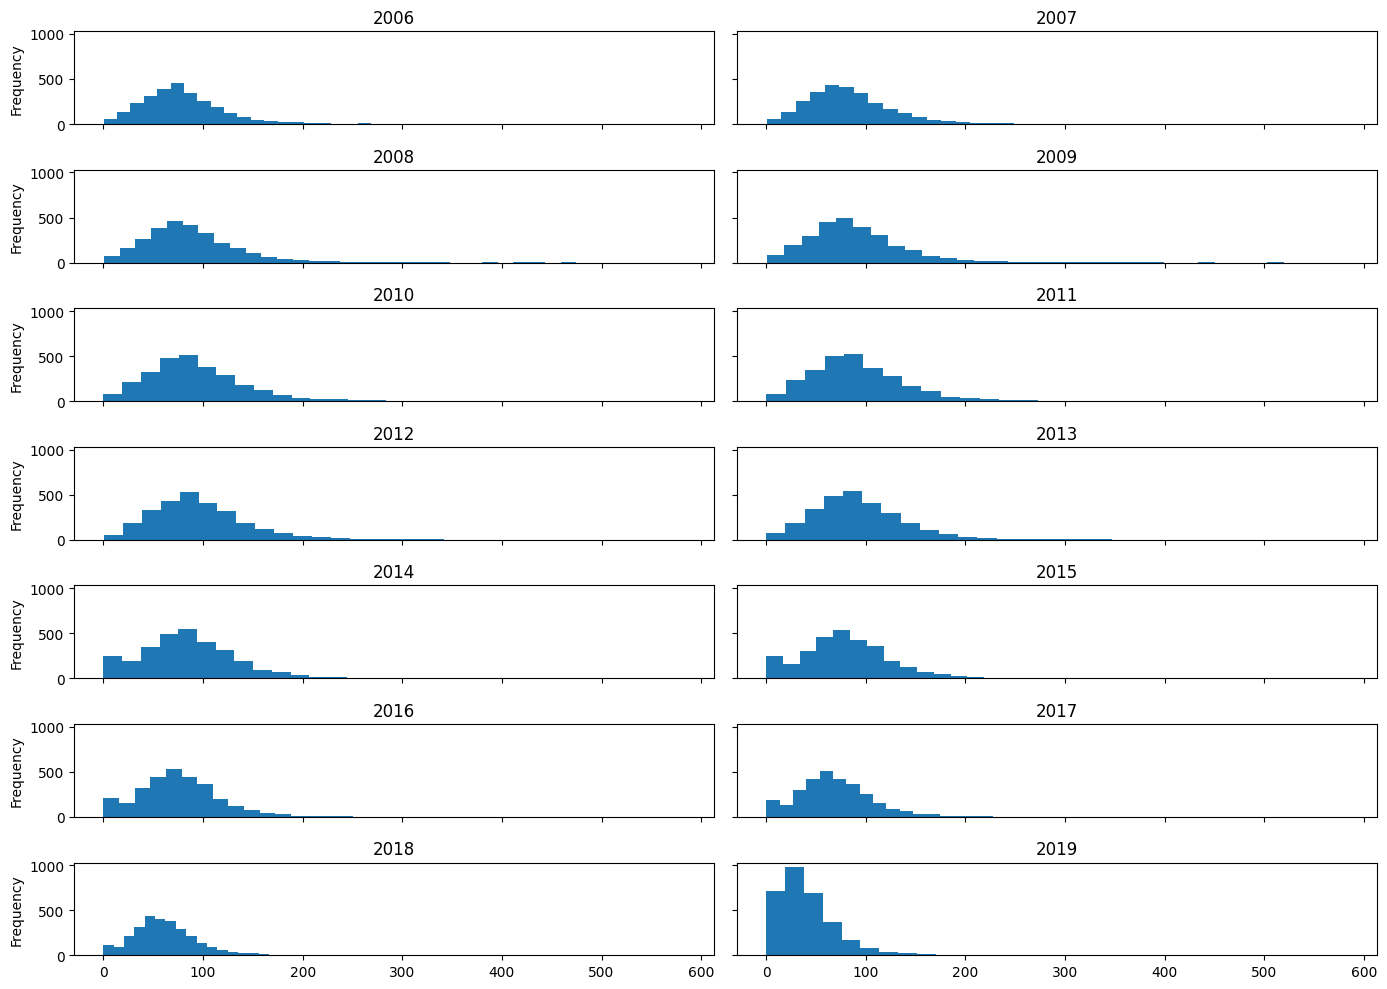

In [7]:
(
    df[["Opioid Dispensing Rate per 100", "year"]].plot.hist(
        by="year",
        figsize=(14, 10),
        layout=(7, 2),
        sharex=True,
        sharey=True,
        legend=False,
        bins=30,
    )
)

plt.tight_layout()

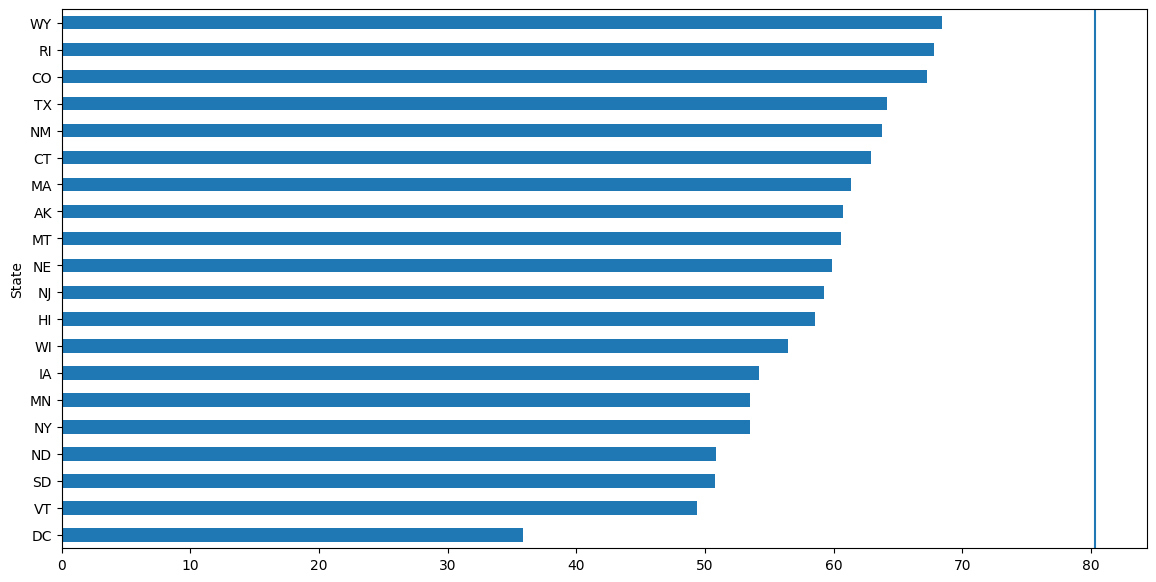

In [8]:
plt.figure(figsize=(14, 7))

(
    df
    .groupby("State")["Opioid Dispensing Rate per 100"]
    .mean()
    .sort_values()
    .head(20)
    .plot.barh()
)

plt.axvline(x=df['Opioid Dispensing Rate per 100'].mean())

Text(0.5, 1.0, 'Opioid dispensing rate per 100 (2006-2019)')

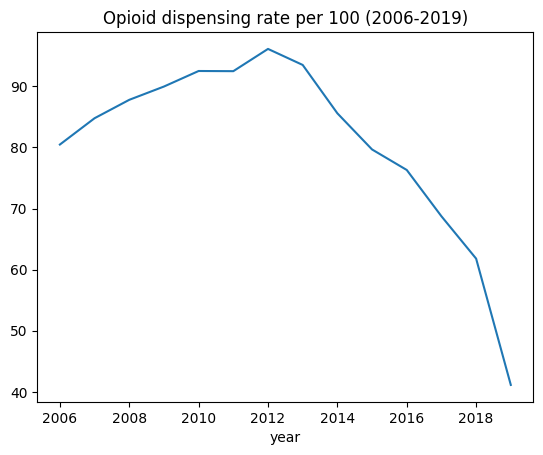

In [9]:
(
    df
    .groupby("year")["Opioid Dispensing Rate per 100"]
    .mean()
    .plot.line()
)

plt.title("Opioid dispensing rate per 100 (2006-2019)")

In [10]:
trydf = df.copy()
geo_df = gpd.read_file("./data/cb_2022_us_county_500k/cb_2022_us_county_500k.shp")
# trydf = trydf.query("year == 2019")
trydf = trydf.rename(columns={"County FIPS Code": "GEOID"})
trydf["GEOID"] = trydf["GEOID"].astype("str")
geo_df["GEOID"] = geo_df["GEOID"].str.lstrip("0")
geo_df["GEOID"] = geo_df["GEOID"].astype("str")
trydf["year"] = trydf["year"].astype("int")

In [11]:
gdf = geo_df.merge(trydf, how="left", on="GEOID").drop(
    columns=[
        "STATEFP",
        "COUNTYFP",
        "COUNTYNS",
        "AFFGEOID",
        "LSAD",
        "ALAND",
        "AWATER",
        "Unnamed: 0",
    ]
)

In [ ]:
# https://stackoverflow.com/questions/67575936/moving-alaska-and-hawaii-in-geopandas-for-choropleths
vmin = gdf["Opioid Dispensing Rate per 100"].min()
vmax = gdf["Opioid Dispensing Rate per 100"].max()

plot_extra = True
for i in range(2006, 2020):
    print(f"making {i} plot")
    fig, ax = plt.subplots(1, 1, figsize=(11, 9))

    gdf[~(gdf["State"].isin(["AK", "HI"])) & (gdf["year"] == i)].to_crs(
        epsg=2163
    ).fillna(1e-6).plot(
        column="Opioid Dispensing Rate per 100",
        cmap=matplotlib.cm.Reds,
        legend=True,
        ax=ax,
        legend_kwds={"label": "Opioid Dispensing Rate per 100", "shrink": 0.7},
        edgecolor="k",
        vmin=vmin,
        vmax=vmax
    )
    ax.grid(False)
    ax.axis("off")
    ax.set_title(
        f"Opioid dispensing rate per 100 persons, {i}", fontdict={"fontsize": 25}
    )
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    pos = ax.get_position()
    bottom_shifted = (
        pos.y0 + -0.15
    )  # This value can be adjusted as per the desired shift
    ax.set_position([pos.x0, bottom_shifted, pos.width, pos.height])

    ax_ak = fig.add_axes([0.1, 0.07, 0.2, 0.3])
    gdf[(gdf["State"] == "AK") & (gdf["year"] == i)].to_crs(epsg=3338).fillna(1e-6).plot(
        column="Opioid Dispensing Rate per 100",
        cmap=matplotlib.cm.Reds,
        ax=ax_ak,
        vmin=vmin,
        vmax=vmax,
        edgecolor="k",
    )
    ax_ak.set_title("Alaska")
    ax_ak.grid(False)
    ax_ak.axis("on")
    ax_ak.set_xticks([])
    ax_ak.set_yticks([])
    # set x, y boundary to ensure consistency across visualization
    ax_ak.set_xbound(-2.25e6, 1.5e6)
    ax_ak.set_ybound(0.37e6, 2.40e6)
    ax_ak.set_xticklabels([])
    ax_ak.set_yticklabels([])

    ax_hi = fig.add_axes([0.43, 0.05, 0.2, 0.3])
    gdf[(gdf["State"] == "HI") & (gdf["year"] == i)].to_crs(epsg=4326).fillna(1e-6).plot(
        column="Opioid Dispensing Rate per 100",
        cmap=matplotlib.cm.Reds,
        ax=ax_hi,
        vmin=vmin,
        vmax=vmax,
        edgecolor="k",
    )
    ax_hi.set_title("Hawaii")
    ax_hi.grid(False)
    ax_hi.axis("on")
    ax_hi.set_xticks([])
    ax_hi.set_yticks([])
    ax_hi.set_xticklabels([])
    ax_hi.set_yticklabels([])

    if plot_extra:
        #
        ax_pp = fig.add_axes([1, 0.58, 0.3, 0.27])
        mean_df = (
            gdf.groupby("year")["Opioid Dispensing Rate per 100"].mean().reset_index()
        )
        ax_pp.plot_date(
            pd.to_datetime(i, format="%Y"),
            [mean_df.loc[i - 2006]["Opioid Dispensing Rate per 100"]],
            "go",
        )
        mean_df["year"] = pd.to_datetime(mean_df["year"], format="%Y")
        mean_df[["year", "Opioid Dispensing Rate per 100"]].plot(
            x="year", y="Opioid Dispensing Rate per 100", ax=ax_pp
        )
        ax_pp.set_title("Yearly trend of national mean dispensing rate")
        ax_pp.set_ylabel("Dispensing rate per 100 persons")
        ax_pp.annotate(
            f"{i} Mean: {str(round(mean_df.loc[i-2006]['Opioid Dispensing Rate per 100'], 1))}",
            xy=(pd.to_datetime(2007, format="%Y"), 45),
        )
        ax_pp.get_legend().remove()

        # histogram of dispensing rate of year
        ax_hist = fig.add_axes([1, 0.2, 0.3, 0.27])
        gdf[gdf["year"] == i]["Opioid Dispensing Rate per 100"].plot(
            kind="hist", ax=ax_hist, bins=30
        )
        ax_hist.set_title(f"Distribution of dispensing rate for {i}")
        ax_hist.set_xlim(vmin, vmax)

    plt.tight_layout()
    # plt.show()
    plt.savefig(f"./viz_raw/{i}.png", dpi=512, bbox_inches="tight", pad_inches=0.15)
    plt.close()

In [69]:
fname = "./visualization/2006-2019 opioid dispensing rate.gif"

with imageio.get_writer(fname, mode='I', duration=1000) as writer:
    for filename in sorted(os.listdir("./viz_raw/")):
        image = imageio.imread("./viz_raw/" + filename)
        writer.append_data(image)

/var/folders/tk/jsn6b4hd0s71zfyq00x6ldcc0000gn/T/ipykernel_79425/1549127132.py:7: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread("./viz_raw/" + filename)


### Exploratory data analysis - unemployment rate

In [102]:
df_sub = df.query("year == 2006").drop("Unnamed: 0", axis=1)
df_sub['County FIPS Code'] = df_sub['County FIPS Code'].astype("str")
df_sub['County FIPS Code'] = df_sub['County FIPS Code'].str.pad(5, side = "left", fillchar='0')
df_sub

,County,State,County FIPS Code,Opioid Dispensing Rate per 100,year,State_County FIPS Code,State FIPS code
0,"Aleutians East, AK",AK,02013,NaN,2006.0,NaN,NaN
1,"Aleutians West, AK",AK,02016,NaN,2006.0,NaN,NaN
2,"Anchorage, AK",AK,02020,71.500000,2006.0,NaN,NaN
3,"Bethel, AK",AK,02050,NaN,2006.0,NaN,NaN
4,"Bristol Bay, AK",AK,02060,NaN,2006.0,NaN,NaN
...,...,...,...,...,...,...,...
3138,"Sweetwater, WY",WY,56037,97.199997,2006.0,NaN,NaN
3139,"Teton, WY",WY,56039,82.800003,2006.0,NaN,NaN
3140,"Uinta, WY",WY,56041,98.099998,2006.0,NaN,NaN
3141,"Washakie, WY",WY,56043,104.199997,2006.0,NaN,NaN


In [58]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.regression.linear_model import OLS

In [174]:
df_sub.merge(
        unemp_df.loc[:, unemp_df.columns.str.contains(f"FIPS|Unemployment_rate_{y}")],
        how="left",
        right_on = "FIPS_Code",
        left_on = "County FIPS Code"
    )

,County,State,County FIPS Code,Opioid Dispensing Rate per 100,year,State_County FIPS Code,State FIPS code,FIPS_Code,Unemployment_rate_2020
0,AUTAUGA,AL,1001.0,98.300003,2020.0,1001.0,1.0,NaN,NaN
1,BALDWIN,AL,1003.0,65.000000,2020.0,1003.0,1.0,NaN,NaN
2,BARBOUR,AL,1005.0,22.799999,2020.0,1005.0,1.0,NaN,NaN
3,BIBB,AL,1007.0,24.799999,2020.0,1007.0,1.0,NaN,NaN
4,BLOUNT,AL,1009.0,22.799999,2020.0,1009.0,1.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...
3076,SWEETWATER,WY,56037.0,70.000000,2020.0,56037.0,56.0,NaN,NaN
3077,TETON,WY,56039.0,50.599998,2020.0,56039.0,56.0,NaN,NaN
3078,UINTA,WY,56041.0,60.000000,2020.0,56041.0,56.0,NaN,NaN
3079,WASHAKIE,WY,56043.0,40.200001,2020.0,56043.0,56.0,NaN,NaN


In [156]:
unemp_df.loc[:, unemp_df.columns.str.contains(f"FIPS|Unemployment_rate_{y}")]

,FIPS_Code,Unemployment_rate_2020
0,00000,8.1
1,01000,6.4
2,01001,5.3
3,01003,6.1
4,01005,7.7
...,...,...
3272,72145,NaN
3273,72147,NaN
3274,72149,NaN
3275,72151,NaN


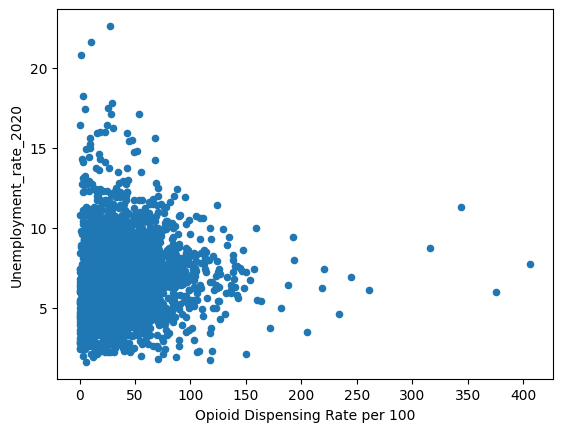

In [186]:
y = 2020

df_sub = df.query(f"year == {y}").drop("Unnamed: 0", axis=1)
df_sub['County FIPS Code'] = df_sub['County FIPS Code'].astype("int").astype("str")
df_sub['County FIPS Code'] = df_sub['County FIPS Code'].str.pad(5, side = "left", fillchar='0')

unemp_dispense = (
    df_sub.merge(
        unemp_df.loc[:, unemp_df.columns.str.contains(f"FIPS|Unemployment_rate_{y}")],
        how="left",
        right_on = "FIPS_Code",
        left_on = "County FIPS Code"
    )
)

unemp_dispense.plot(x = "Opioid Dispensing Rate per 100", y = f"Unemployment_rate_{y}", kind = 'scatter');

In [188]:
unemp_dispense[f'Unemployment_rate_{y}'] = unemp_dispense[f'Unemployment_rate_{y}'].astype("float")
smf.ols(formula = f"Q('Opioid Dispensing Rate per 100') ~ Q('Unemployment_rate_{y}')", data=unemp_dispense).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     OLS Regression Results                                    
===============================================================================================
Dep. Variable:     Q('Opioid Dispensing Rate per 100')   R-squared:                       0.003
Model:                                             OLS   Adj. R-squared:                  0.003
Method:                                  Least Squares   F-statistic:                     10.20
Date:                                 Mon, 30 Oct 2023   Prob (F-statistic):            0.00142
Time:                                         21:47:01   Log-Likelihood:                -14938.
No. Observations:                                 3081   AIC:                         2.988e+04
Df Residuals:                                     3079   BIC:                         2.989e+04
Df Model:                                            1                                         
Covariance Type:                             nonrobust                                         
===============================================================================================
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept                      33.5290      1.733     19.346      0.000      30.131      36.927
Q('Unemployment_rate_2020')     0.7704      0.241      3.193      0.001       0.297       1.243
==============================================================================
Omnibus:                     2116.103   Durbin-Watson:                   1.835
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            55004.842
Skew:                           2.898   Prob(JB):                         0.00
Kurtosis:                      22.871   Cond. No.                         22.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [129]:
df.reset_index()

,index,Unnamed: 0,County,State,County FIPS Code,Opioid Dispensing Rate per 100,year,State_County FIPS Code,State FIPS code
0,0,0.0,"Aleutians East, AK",AK,2013,NaN,2008.0,NaN,NaN
1,1,1.0,"Aleutians West, AK",AK,2016,NaN,2008.0,NaN,NaN
2,2,2.0,"Anchorage, AK",AK,2020,75.599998,2008.0,NaN,NaN
3,3,3.0,"Bethel, AK",AK,2050,NaN,2008.0,NaN,NaN
4,4,4.0,"Bristol Bay, AK",AK,2060,NaN,2008.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...
46580,3138,3138.0,"Sweetwater, WY",WY,56037,92.000000,2011.0,NaN,NaN
46581,3139,3139.0,"Teton, WY",WY,56039,80.500000,2011.0,NaN,NaN
46582,3140,3140.0,"Uinta, WY",WY,56041,84.099998,2011.0,NaN,NaN
46583,3141,3141.0,"Washakie, WY",WY,56043,83.400002,2011.0,NaN,NaN


In [132]:
mi = df.reset_index().groupby('year')['Opioid Dispensing Rate per 100'].idxmax() 

df.reset_index().loc[mi]

,index,Unnamed: 0,County,State,County FIPS Code,Opioid Dispensing Rate per 100,year,State_County FIPS Code,State FIPS code
36936,2923,2923.0,"Martinsville, VA",VA,51690,403.299988,2006.0,NaN,NaN
33793,2923,2923.0,"Martinsville, VA",VA,51690,438.399994,2007.0,NaN,NaN
2923,2923,2923.0,"Martinsville, VA",VA,51690,474.700012,2008.0,NaN,NaN
9147,2923,2923.0,"Martinsville, VA",VA,51690,520.099976,2009.0,NaN,NaN
43222,2923,2923.0,"Martinsville, VA",VA,51690,566.400024,2010.0,NaN,NaN
46365,2923,2923.0,"Martinsville, VA",VA,51690,583.799988,2011.0,NaN,NaN
40082,2926,2926.0,"Norton, VA",VA,51720,570.099976,2012.0,NaN,NaN
30653,2926,2926.0,"Norton, VA",VA,51720,578.099976,2013.0,NaN,NaN
21412,2926,2926.0,"Norton, VA",VA,51720,563.299988,2014.0,NaN,NaN
18269,2926,2926.0,"Norton, VA",VA,51720,504.899994,2015.0,NaN,NaN


#### State level dispensing rate

In [192]:
from jenkspy import JenksNaturalBreaks

In [352]:
state_rx = df.groupby(['State', 'year'], as_index=False).agg({"Opioid Dispensing Rate per 100": "mean"})

jnb = JenksNaturalBreaks(5)
jnb.fit(state_rx['Opioid Dispensing Rate per 100'])

cls = []
for i in range(len(jnb.breaks_)):
     try: 
          a = str(round(jnb.breaks_[i], 1))
          b = str(round(jnb.breaks_[i+1], 1))
          cls.append(f"{a}-{b}")
     except:
          pass

state_rx['cls'] = state_rx['Opioid Dispensing Rate per 100'].apply(lambda x: "abcde"[jnb.predict(x)])

In [216]:
sgdf = gpd.read_file("./data/cb_2022_us_state_500k/cb_2022_us_state_500k.shp")

In [289]:
sgdf = state_geo_df.drop(['ALAND', 'AWATER','GEOID', 'AFFGEOID', 'STATENS'], axis=1)

In [353]:
strx_gdf = sgdf[['STUSPS', 'geometry']].merge(state_rx, how="right", left_on="STUSPS", right_on="State")
strx_gdf.head(5)

,STUSPS,geometry,State,year,Opioid Dispensing Rate per 100,cls
0,AK,"MULTIPOLYGON (((-152.85279 70.89539, -152.8498...",AK,2006.0,84.533333,c
1,AK,"MULTIPOLYGON (((-152.85279 70.89539, -152.8498...",AK,2007.0,80.070000,c
2,AK,"MULTIPOLYGON (((-152.85279 70.89539, -152.8498...",AK,2008.0,82.590004,c
3,AK,"MULTIPOLYGON (((-152.85279 70.89539, -152.8498...",AK,2009.0,82.650002,c
4,AK,"MULTIPOLYGON (((-152.85279 70.89539, -152.8498...",AK,2010.0,84.270004,c


In [364]:
# https://stackoverflow.com/questions/67575936/moving-alaska-and-hawaii-in-geopandas-for-choropleths
vmin = strx_gdf["Opioid Dispensing Rate per 100"].min()
vmax = strx_gdf["Opioid Dispensing Rate per 100"].max()

plot_extra = True
for i in range(2006, 2021):
    print(f"making {i} plot")
    fig, ax = plt.subplots(1, 1, figsize=(11, 9))

    
    strx_gdf[~(strx_gdf["State"].isin(["AK", "HI"])) & (strx_gdf["year"] == i)].to_crs(
        epsg=2163
    ).fillna(1e-6).plot(
        column="Opioid Dispensing Rate per 100",
        cmap=matplotlib.cm.Reds,
        legend=True,
        ax=ax,
        legend_kwds={"label": "Opioid Dispensing Rate per 100", "shrink": 0.7},
        edgecolor="k",
        vmin=vmin,
        vmax=vmax
    )
    ax.grid(False)
    ax.axis("off")
    ax.set_title(
        f"Opioid dispensing rate per 100 persons, {i}", fontdict={"fontsize": 25}
    )
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    pos = ax.get_position()
    bottom_shifted = (
        pos.y0 + -0.15
    )  # This value can be adjusted as per the desired shift
    ax.set_position([pos.x0, bottom_shifted, pos.width, pos.height])

    ax_ak = fig.add_axes([0.1, 0.07, 0.2, 0.3])
    strx_gdf[(strx_gdf["State"] == "AK") & (strx_gdf["year"] == i)].to_crs(epsg=3338).fillna(1e-6).plot(
        column="Opioid Dispensing Rate per 100",
        cmap=matplotlib.cm.Reds,
        ax=ax_ak,
        vmin=vmin,
        vmax=vmax,
        edgecolor="k",
    )
    ax_ak.set_title("Alaska")
    ax_ak.grid(False)
    ax_ak.axis("on")
    ax_ak.set_xticks([])
    ax_ak.set_yticks([])
    # set x, y boundary to ensure consistency across visualization
    ax_ak.set_xbound(-2.25e6, 1.5e6)
    ax_ak.set_ybound(0.37e6, 2.40e6)
    ax_ak.set_xticklabels([])
    ax_ak.set_yticklabels([])

    ax_hi = fig.add_axes([0.43, 0.05, 0.2, 0.3])
    strx_gdf[(strx_gdf["State"] == "HI") & (strx_gdf["year"] == i)].to_crs(epsg=4326).fillna(1e-6).plot(
        column="Opioid Dispensing Rate per 100",
        cmap=matplotlib.cm.Reds,
        ax=ax_hi,
        vmin=vmin,
        vmax=vmax,
        edgecolor="k",
    )
    ax_hi.set_title("Hawaii")
    ax_hi.grid(False)
    ax_hi.axis("on")
    ax_hi.set_xticks([])
    ax_hi.set_yticks([])
    ax_hi.set_xticklabels([])
    ax_hi.set_yticklabels([])

    if plot_extra:
        #
        ax_pp = fig.add_axes([1, 0.58, 0.3, 0.27])
        mean_df = (
            strx_gdf.groupby("year")["Opioid Dispensing Rate per 100"].mean().reset_index()
        )
        ax_pp.plot_date(
            pd.to_datetime(i, format="%Y"),
            [mean_df.loc[i - 2006]["Opioid Dispensing Rate per 100"]],
            "go",
        )
        mean_df["year"] = pd.to_datetime(mean_df["year"], format="%Y")
        mean_df[["year", "Opioid Dispensing Rate per 100"]].plot(
            x="year", y="Opioid Dispensing Rate per 100", ax=ax_pp
        )
        ax_pp.set_title("Yearly trend of national mean dispensing rate")
        ax_pp.set_ylabel("Dispensing rate per 100 persons")
        ax_pp.annotate(
            f"{i} Mean: {str(round(mean_df.loc[i-2006]['Opioid Dispensing Rate per 100'], 1))}",
            xy=(pd.to_datetime(2007, format="%Y"), 45),
        )
        ax_pp.get_legend().remove()

        # histogram of dispensing rate of year
        ax_hist = fig.add_axes([1, 0.2, 0.3, 0.27])
        strx_gdf[strx_gdf["year"] == i]["Opioid Dispensing Rate per 100"].plot(
            kind="hist", ax=ax_hist, bins=15
        )
        ax_hist.set_title(f"Distribution of dispensing rate for {i}")
        ax_hist.set_xlim(vmin, vmax)

    plt.tight_layout()
    # plt.show()
    plt.savefig(f"./viz_raw/state/{i}.png", dpi=512, bbox_inches="tight", pad_inches=0.15)
    plt.close()

fname = "./visualization/2006-2020 state continuous opioid dispensing rate.gif"

with imageio.get_writer(fname, mode='I', duration=1000) as writer:
    for filename in sorted([f for f in os.listdir(os.curdir + "/viz_raw/state/") if os.path.isfile(os.curdir + "/viz_raw/state/" + f)]):
        image = imageio.imread("./viz_raw/state/" + filename)
        writer.append_data(image)

making 2006 plot


/var/folders/tk/jsn6b4hd0s71zfyq00x6ldcc0000gn/T/ipykernel_26157/179515002.py:106: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


making 2007 plot


/var/folders/tk/jsn6b4hd0s71zfyq00x6ldcc0000gn/T/ipykernel_26157/179515002.py:106: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


making 2008 plot


/var/folders/tk/jsn6b4hd0s71zfyq00x6ldcc0000gn/T/ipykernel_26157/179515002.py:106: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


making 2009 plot


/var/folders/tk/jsn6b4hd0s71zfyq00x6ldcc0000gn/T/ipykernel_26157/179515002.py:106: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


making 2010 plot


/var/folders/tk/jsn6b4hd0s71zfyq00x6ldcc0000gn/T/ipykernel_26157/179515002.py:106: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


making 2011 plot


/var/folders/tk/jsn6b4hd0s71zfyq00x6ldcc0000gn/T/ipykernel_26157/179515002.py:106: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


making 2012 plot


/var/folders/tk/jsn6b4hd0s71zfyq00x6ldcc0000gn/T/ipykernel_26157/179515002.py:106: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


making 2013 plot


/var/folders/tk/jsn6b4hd0s71zfyq00x6ldcc0000gn/T/ipykernel_26157/179515002.py:106: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


making 2014 plot


/var/folders/tk/jsn6b4hd0s71zfyq00x6ldcc0000gn/T/ipykernel_26157/179515002.py:106: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


making 2015 plot


/var/folders/tk/jsn6b4hd0s71zfyq00x6ldcc0000gn/T/ipykernel_26157/179515002.py:106: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


making 2016 plot


/var/folders/tk/jsn6b4hd0s71zfyq00x6ldcc0000gn/T/ipykernel_26157/179515002.py:106: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


making 2017 plot


/var/folders/tk/jsn6b4hd0s71zfyq00x6ldcc0000gn/T/ipykernel_26157/179515002.py:106: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


making 2018 plot


/var/folders/tk/jsn6b4hd0s71zfyq00x6ldcc0000gn/T/ipykernel_26157/179515002.py:106: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


making 2019 plot


/var/folders/tk/jsn6b4hd0s71zfyq00x6ldcc0000gn/T/ipykernel_26157/179515002.py:106: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


making 2020 plot


/var/folders/tk/jsn6b4hd0s71zfyq00x6ldcc0000gn/T/ipykernel_26157/179515002.py:106: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


In [ ]:
# https://stackoverflow.com/questions/67575936/moving-alaska-and-hawaii-in-geopandas-for-choropleths
vmin = strx_gdf["Opioid Dispensing Rate per 100"].min()
vmax = strx_gdf["Opioid Dispensing Rate per 100"].max()
from matplotlib.patches import Patch
colmap = plt.cm.Reds

plot_color = [mcolors.to_hex(c) for c in colmap([0.2, 0.4, 0.6, 0.8, 1.0])]
color_dict = {i:c for i,c in zip("abcde", plot_color)}

plot_extra = True
for i in range(2006, 2021):
    print(f"making {i} plot")
    fig, ax = plt.subplots(1, 1, figsize=(11, 9))

    filtered_data = filtered_data = strx_gdf[~(strx_gdf["State"].isin(["AK", "HI"])) & (strx_gdf["year"] == i)].to_crs(epsg=2163)
    filtered_data.plot(
        # column="Opioid Dispensing Rate per 100",
        # scheme="user_defined",
        # classification_kwds=dict(bins=jnb.breaks_),
        column="cls",
        categorical=True,
        # cmap=colors.ListedColormap(list(color_dict.values())),
        color = filtered_data["cls"].map(color_dict),
        legend=True,
        ax=ax,
        legend_kwds={"frameon": False, "labels": cls, 'loc':'lower right'},
        edgecolor="k",
    )

    legend_patches = [Patch(color=color_dict[cls], label=cls) for cls in color_dict.keys()]
    ax.legend(handles=legend_patches, frameon=False, loc='lower right', labels=cls)

    ax.grid(False)
    ax.axis("off")
    ax.set_title(
        f"Opioid dispensing rate per 100 persons, {i}", fontdict={"fontsize": 25}
    )
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    pos = ax.get_position()
    bottom_shifted = (
        pos.y0 + -0.15
    )  # This value can be adjusted as per the desired shift
    ax.set_position([pos.x0, bottom_shifted, pos.width, pos.height])

    ax_ak = fig.add_axes([0.1, 0.07, 0.2, 0.2])
    strx_gdf[(strx_gdf["State"] == "AK") & (strx_gdf["year"] == i)].to_crs(
        epsg=3338
    ).fillna(1e-6).plot(
        column="cls",
        categorical=True,
        # cmap=colors.ListedColormap(list(color_dict.values())),
        color = filtered_data["cls"].map(color_dict),
        ax=ax_ak,
        edgecolor="k",
    )
    ax_ak.set_title("Alaska")
    ax_ak.grid(False)
    ax_ak.axis("on")
    ax_ak.set_xticks([])
    ax_ak.set_yticks([])
    # set x, y boundary to ensure consistency across visualization
    ax_ak.set_xbound(-2.25e6, 1.5e6)
    ax_ak.set_ybound(0.37e6, 2.40e6)
    ax_ak.set_xticklabels([])
    ax_ak.set_yticklabels([])

    ax_hi = fig.add_axes([0.59, 0.05, 0.2, 0.2])
    strx_gdf[(strx_gdf["State"] == "HI") & (strx_gdf["year"] == i)].to_crs(
        epsg=4326
    ).fillna(1e-6).plot(
        column="cls",
        categorical=True,
        # cmap=colors.ListedColormap(list(color_dict.values())),
        color = filtered_data["cls"].map(color_dict),
        ax=ax_hi,
        edgecolor="k",
    )
    ax_hi.set_title("Hawaii")
    ax_hi.grid(False)
    ax_hi.axis("on")
    ax_hi.set_xticks([])
    ax_hi.set_yticks([])
    ax_hi.set_xticklabels([])
    ax_hi.set_yticklabels([])

    if plot_extra:
        #
        ax_pp = fig.add_axes([1, 0.58, 0.3, 0.27])
        mean_df = (
            strx_gdf.groupby("year")["Opioid Dispensing Rate per 100"]
            .mean()
            .reset_index()
        )
        ax_pp.plot_date(
            pd.to_datetime(i, format="%Y"),
            [mean_df.loc[i - 2006]["Opioid Dispensing Rate per 100"]],
            "go",
        )
        mean_df["year"] = pd.to_datetime(mean_df["year"], format="%Y")
        mean_df[["year", "Opioid Dispensing Rate per 100"]].plot(
            x="year", y="Opioid Dispensing Rate per 100", ax=ax_pp
        )
        ax_pp.set_title("Yearly trend of national mean dispensing rate")
        ax_pp.set_ylabel("Dispensing rate per 100 persons")
        ax_pp.annotate(
            f"{i} Mean: {str(round(mean_df.loc[i-2006]['Opioid Dispensing Rate per 100'], 1))}",
            xy=(pd.to_datetime(2007, format="%Y"), 45),
        )
        ax_pp.get_legend().remove()

        # histogram of dispensing rate of year
        ax_hist = fig.add_axes([1, 0.2, 0.3, 0.27])
        strx_gdf[strx_gdf["year"] == i]["Opioid Dispensing Rate per 100"].plot(
            kind="hist", ax=ax_hist, bins=15
        )
        ax_hist.set_title(f"Distribution of dispensing rate for {i}")
        ax_hist.set_xlim(vmin, vmax)

    plt.tight_layout()
    # plt.show()
    plt.savefig(f"./viz_raw/state_jnb/{i}.png", dpi=512, bbox_inches="tight", pad_inches=0.15)
    plt.close()

fname = "./visualization/2006-2020 state opioid dispensing rate.gif"

with imageio.get_writer(fname, mode='I', duration=1000) as writer:
    for filename in sorted([f for f in os.listdir(os.curdir + "/viz_raw") if os.path.isfile(os.curdir + "/viz_raw/" + f)]):
        image = imageio.imread("./viz_raw/" + filename)
        writer.append_data(image)

### DO NOT USE

In [310]:
import matplotlib.pyplot as plt
import matplotlib
import cartopy
import cartopy.crs as ccrs
import cartopy.io.shapereader as shpreader
import shapely.geometry as sgeom  #for box drawing
import geopandas as gpd
import numpy as np
import mapclassify as mc
import pandas as pd

my_colormap = matplotlib.cm.Reds
edgecolor = "black"

In [ ]:
newusa = gdf.copy()
col = "Opioid Dispensing Rate per 100"


# A function that draws inset map
def add_insetmap(axes_extent, map_extent, state_name, facecolor, edgecolor, geometry):
    # create new axes, set its projection
    use_projection = ccrs.Mercator()  # preserves shape
    geodetic = ccrs.Geodetic(globe=ccrs.Globe(datum="WGS84"))
    sub_ax = plt.axes(axes_extent, projection=use_projection)  # normal units
    sub_ax.set_extent(map_extent, geodetic)  # map extents

    # option to add basic land, coastlines of the map
    # can comment out if you don't need them
    sub_ax.add_feature(cartopy.feature.LAND)
    sub_ax.coastlines()
    sub_ax.set_title(state_name)

    # add map `geometry`
    sub_ax.add_geometries(
        [geometry], ccrs.Mercator(), facecolor=facecolor, edgecolor=edgecolor, lw=0.4,
    )

    # plot box around the map
    extent_box = sgeom.box(map_extent[0], map_extent[2], map_extent[1], map_extent[3])
    sub_ax.add_geometries([extent_box], ccrs.PlateCarree(), color="none")


# excluding non-conterminous states
usa_main = newusa[~newusa["State"].isin(["AK", "HI"])]
usa_main.crs = {"init": "epsg:4326"}
usa_main = usa_main.to_crs(epsg=2163)

# non-conterminous states, namely, Alaska and Hawaii
usa_more = newusa[newusa["State"].isin(["AK", "HI"])]  # include these
usa_more.crs = {"init": "epsg:4326"}
usa_more = usa_more.to_crs(epsg=2163)

# plot 1st part, using usa_main and grab its axis as 'ax2'
ax2 = usa_main.plot(
    column=col, legend=False, cmap=matplotlib.cm.Reds, ec=edgecolor, lw=0.4
)

# manipulate colorbar/legend
fig = ax2.get_figure()
cax = fig.add_axes([0.9, 0.25, 0.02, 0.5])  # [left,bottom,width,height]
sm = plt.cm.ScalarMappable(
    cmap=my_colormap, norm=plt.Normalize(vmin=min(newusa[col]), vmax=max(newusa[col]))
)

# # clear the array of the scalar mappable
sm._A = []
cb = fig.colorbar(sm, cax=cax)

cb.set_label("Opioid dispensing rate 2019")
ax2.set_frame_on(False)
ax2.set_xticks([])
ax2.set_yticks([])
ax2.set_xticklabels([])
ax2.set_yticklabels([])
ax2.set_title("Opioid dispensing rate 2019")

# plot Alaska, Hawaii as inset maps
for index, state in usa_more.dissolve(by='State').iterrows():
    st_name = index
    facecolor = my_colormap(state[col] / max(newusa[col]))
    if st_name == "AK":
        map_extent = (-180, -125, 46, 73)
        axes_extent = (0.04, 0.06, 0.29, 0.275)
    elif st_name == "HI":
        map_extent = (-162, -152, 15, 25)
        axes_extent = (0.27, 0.06, 0.15, 0.15)
    add_insetmap(
        axes_extent, map_extent, st_name, facecolor, edgecolor, state["geometry"]
    )
plt.show()

### Try 

/Users/randy/.conda/envs/numpy_m1_build/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


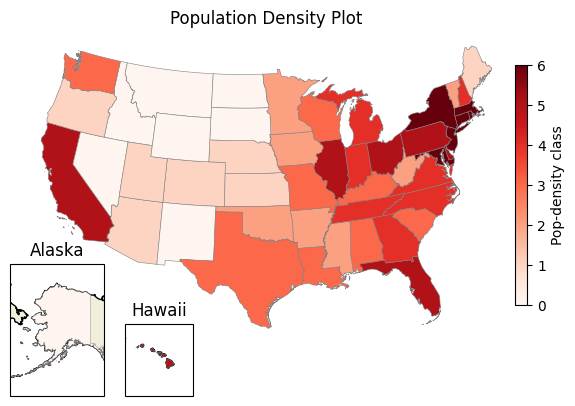

In [307]:
import matplotlib.pyplot as plt
import matplotlib
import cartopy
import cartopy.crs as ccrs
import cartopy.io.shapereader as shpreader
import shapely.geometry as sgeom  #for box drawing
import geopandas as gpd
import numpy as np
import mapclassify as mc
import pandas as pd

import requests
import json

# population per sq-km
# include `Puerto Rico` but not used
popdensity = {
    'Alaska': 0.8,
    'District of Columbia': 4251,
    'Hawaii': 86,
    'Puerto Rico': 360,
    'New Jersey': 438.00,
    'Rhode Island': 387.35,
    'Massachusetts': 312.68,
    'Connecticut': 271.40,
    'Maryland': 209.23,
    'New York': 155.18,
    'Delaware': 154.87,
    'Florida': 114.43,
    'Ohio':  107.05,
    'Pennsylvania': 105.80,
    'Illinois': 86.27,
    'California': 83.85,
    'Virginia': 69.03,
    'Michigan': 67.55,
    'Indiana': 65.46,
    'North Carolina': 63.80,
    'Georgia': 54.59,
    'Tennessee': 53.29,
    'New Hampshire': 53.20,
    'South Carolina': 51.45,
    'Louisiana': 39.61,
    'Kentucky': 39.28,
    'Wisconsin': 38.13,
    'Washington': 34.20,
    'Alabama': 33.84,
    'Missouri': 31.36,
    'Texas': 30.75,
    'West Virginia': 29.00,
    'Vermont': 25.41,
    'Minnesota': 23.86,
    'Mississippi': 23.42,
    'Iowa': 20.22,
    'Arkansas': 19.82,
    'Oklahoma': 19.40,
    'Arizona': 17.43,
    'Colorado': 16.01,
    'Maine': 15.95,
    'Oregon': 13.76,
    'Kansas': 12.69,
    'Utah': 10.50,
    'Nebraska': 8.60,
    'Nevada': 7.03,
    'Idaho': 6.04,
    'New Mexico': 5.79,
    'South Dakota': 3.84,
    'North Dakota': 3.59,
    'Montana': 2.39,
    'Wyoming': 1.96}

# use this simple colormap
my_colormap = matplotlib.cm.Reds

# some settings
edgecolor = "gray"

# use this column for thematic mapping
theme_value = "pop_per_sqkm"

# A function that draws inset map
# ===============================
def add_insetmap(axes_extent, map_extent, state_name, facecolor, edgecolor, geometry):
    # create new axes, set its projection
    use_projection = ccrs.Mercator()      # preserves shape
    #use_projection = ccrs.PlateCarree()  # large distortion in E-W, bad for for Alaska
    geodetic = ccrs.Geodetic(globe=ccrs.Globe(datum='WGS84'))
    sub_ax = plt.axes(axes_extent, projection=use_projection)  # normal units
    sub_ax.set_extent(map_extent, geodetic)  # map extents

    # option to add basic land, coastlines of the map
    # can comment out if you don't need them
    sub_ax.add_feature(cartopy.feature.LAND)
    sub_ax.coastlines()
    sub_ax.set_title(state_name)

    # add map `geometry`
    sub_ax.add_geometries([geometry], ccrs.PlateCarree(), \
                          facecolor=facecolor, edgecolor=edgecolor, lw=0.3)
    # +++ more features can be added here +++
    # plot box around the map
    extent_box = sgeom.box(map_extent[0], map_extent[2], map_extent[1], map_extent[3])
    sub_ax.add_geometries([extent_box], ccrs.PlateCarree(), color='none')

# access USA shapefile
# use data from internet
URL = 'https://github.com/kjhealy/us-county/raw/master/data/geojson/gz_2010_us_040_00_500k.json'

# more hard-code for settings
state_name = "NAME"  #defined column header
fname = "usa_json.json"

# Only on the first-run, set True in the next statement
if True:
    us_json = requests.get(URL).json()
    with open(fname, 'w') as file:
         file.write(json.dumps(us_json))

# saved it to disk as fname 
# then load from file
usa = gpd.read_file(fname)
usa.sort_values(state_name, inplace=True)

# make dataframe from population data `popdensity` dict object
usa_popden = pd.DataFrame.from_dict(popdensity, orient='index', 
                                  columns=['pop_per_sqkm'])
# merge `usa_popden` to main dataframe, `usa`
newusa = usa.merge(usa_popden, how='left', left_on='NAME', right_index=True)
# take only some columns in `newusa` for our operation
newusa = newusa[['NAME', 'pop_per_sqkm', 'geometry']]

# Data classification for thematic mapping
# choose number of classes of population density
# classes --> assigned colors in thematic mapping
num_classes = 7  #will get class-values: 0,1,2,3,4,5,6
sclass = mc.Quantiles(newusa["pop_per_sqkm"].values, k=num_classes)
#print(sclass)

# add new column, "sclass", for raw class values, sclass.yb
# its values will be used to assign color for polygon's facecolor
newusa["sclass"] = sclass.yb

# extract parts of the whole 'newusa' geodataframe for separate plotting/manipulation
# 'usa_main': excluding non-conterminous states
usa_main = newusa[~newusa[state_name].isin(["Alaska", "Hawaii", "Puerto Rico"])] # exclude these
#  re-project usa_main to equal-area conic projection "EPSG:2163"
usa_main.crs = {'init': 'epsg:4326'}
usa_main = usa_main.to_crs(epsg=2163)

# 'usa_more': non-conterminous states, namely, Alaska and Hawaii
usa_more = newusa[newusa[state_name].isin(["Alaska", "Hawaii"])]  # include these

# ------------ Plot --------------
# plot 1st part, using usa_main and grab its axis as 'ax2'
ax2 = usa_main.plot(column="sclass", legend=False, 
                    cmap=matplotlib.cm.Reds, ec=edgecolor, lw=0.4)

# manipulate colorbar/legend
fig = ax2.get_figure()
cax = fig.add_axes([0.9, .25, 0.02, 0.5])  #[left,bottom,width,height]
sm = plt.cm.ScalarMappable(cmap=my_colormap, 
        norm=plt.Normalize(vmin=min(newusa["sclass"]),vmax=max(newusa["sclass"])))

# clear the array of the scalar mappable
sm._A = []
cb = fig.colorbar(sm, cax=cax)
cb.set_label("Pop-density class")
# manipulate the axis seetings
ax2.set_frame_on(False)
ax2.set_xticks([])
ax2.set_yticks([])
ax2.set_xticklabels([])
ax2.set_yticklabels([])
ax2.set_title("Population Density Plot")

# add more features on ax2
# plot Alaska, Hawaii as inset maps
for index,state in usa_more.iterrows():

    if state[state_name] in ("Alaska", "Hawaii"):
        st_name = state[state_name]

        # set fill color, using normalized `sclass` on `my_colormap`
        facecolor = my_colormap( state["sclass"] / max(newusa["sclass"] ))

        if st_name == "Alaska":
            # (1) Alaska
            # Custom extent, relative size
            map_extent = (-178, -135, 46, 73)    # degrees: (lonmin,lonmax,latmin,latmax)
            axes_extent = (0.04, 0.06, 0.29, 0.275) # axes units: 0 to 1, (LLx,LLy,width,height)

        if st_name == "Hawaii":
            # (2) Hawaii
            # Custom extent, relative size
            map_extent = (-162, -152, 15, 25)
            axes_extent = (0.27, 0.06, 0.15, 0.15)

        # add inset maps
        add_insetmap(axes_extent, map_extent, st_name, \
                     facecolor, \
                     edgecolor, \
                     state["geometry"])

plt.show()


In [479]:
import sys
sys.modules[__name__].__dict__.clear()

# References

1. https://stackoverflow.com/questions/55767312/how-to-position-suptitle
2. https://stackoverflow.com/questions/12444716/how-do-i-set-the-figure-title-and-axes-labels-font-size
3. https://geopandas.org/en/stable/docs/user_guide/missing_empty.html
4. 